In [2]:
import pytides2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from   datetime import datetime, timedelta
import matplotlib as mpl
import glob
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib import font_manager as fm
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from netCDF4 import Dataset, num2date
import mat73
import scipy as sp
import warnings
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cdsapi
import seaborn as sns

warnings.filterwarnings('ignore')


plt.style.use('default')

In [3]:
path_font=r"G:\My Drive\TESIS_MAESTRIA_PAULAE\Fonts\Quicksand"

prop1 = fm.FontProperties(fname=path_font+'\Quicksand-Medium.ttf')
prop2 = fm.FontProperties(fname=path_font+'\Quicksand-SemiBold.ttf')
prop1.set_size(12)

In [4]:
def mask_ (len_lat, len_lon, mes, X_andY):
    """
    Inputs: 
    len_lat: longitud de la latitud
    len_lon: longitud de la longitud
    mes: mes de resultados 
    X_and_Y: dataframe de X y Ys: Y_true y Y_predicha
    ----------------------------------------------------
    return: 
    mask: mascara de Y 
    mask_pre: mascara de Y_predicha
    """
    df_mask = pd.DataFrame(np.c_[np.arange(0,len_lat*len_lon,1)*np.nan,np.arange(0,len_lat*len_lon,1)*np.nan], columns = ['mask', 'mask_pre'])
    index = X_andY[df_db['mes']==mes]['index'].values
    df_mask['mask'].iloc[np.where([df_mask.index == i for i in index])[1]] = X_andY[df_db['mes']==mes]['Y']
    df_mask['mask_pre'].iloc[np.where([df_mask.index == i for i in index])[1]] = X_andY[df_db['mes']==mes]['Y_pred']
    mask = df_mask['mask'].values.reshape((len_lat,len_lon))
    mask_pre = df_mask['mask_pre'].values.reshape((len_lat,len_lon))
    return mask, mask_pre

In [8]:
df_coords = pd.read_csv('df_coords.csv')
lat_mesh = df_coords.lat.values.reshape((188, 112))
lon_mesh = df_coords.lon.values.reshape((188,112))
lat = lat_mesh[:,0]
lon = lon_mesh[0,:]

# Base de datos

In [5]:
df_db = pd.read_csv('df_database.csv')
df_db.columns
len_lat = len(lat)
len_lon = len(lon)

In [6]:
df_db.iloc[:,1:]

,index,waterlevel,temp,sal,hs_wave,dir_wave,vel_wind,dir_wind,u_wind,v_wind,vel_flow,dir_flow,u_flow,v_flow,mes
0,46,0.260220,0.260220,0.260220,0.116837,0.116837,0.116837,45.000000,0.116837,0.116837,0.368006,45.0,0.260220,0.260220,1
1,47,0.263163,0.263163,0.263163,0.122465,0.122465,0.122465,45.000000,0.122465,0.122465,0.372168,45.0,0.263163,0.263163,1
2,48,0.258976,0.258976,0.258976,0.130494,0.130494,0.130494,45.000000,0.130494,0.130494,0.366247,45.0,0.258976,0.258976,1
3,49,0.256825,0.256825,0.256825,0.140012,0.140012,0.140012,45.000000,0.140012,0.140012,0.363206,45.0,0.256825,0.256825,1
4,50,0.258829,0.258829,0.258829,0.149988,0.149988,0.149988,45.000000,0.149988,0.149988,0.366040,45.0,0.258829,0.258829,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221371,20939,0.218121,28.110162,35.755665,1.887047,87.019027,9.213161,259.490423,-8.908047,-1.652549,0.781339,225.0,-0.552490,-0.552490,12
221372,20940,0.222498,28.105264,35.748895,1.888027,87.102830,9.229263,259.621510,-8.930887,-1.635659,0.802535,225.0,-0.567478,-0.567478,12
221373,20941,0.226166,28.097134,35.737414,1.888999,87.187034,9.245683,259.752242,-8.953703,-1.618732,0.822391,225.0,-0.581518,-0.581518,12
221374,20942,0.229069,28.081057,35.720507,1.889970,87.271393,9.257756,259.873328,-8.972129,-1.602489,0.838176,225.0,-0.592680,-0.592680,12


<AxesSubplot:>

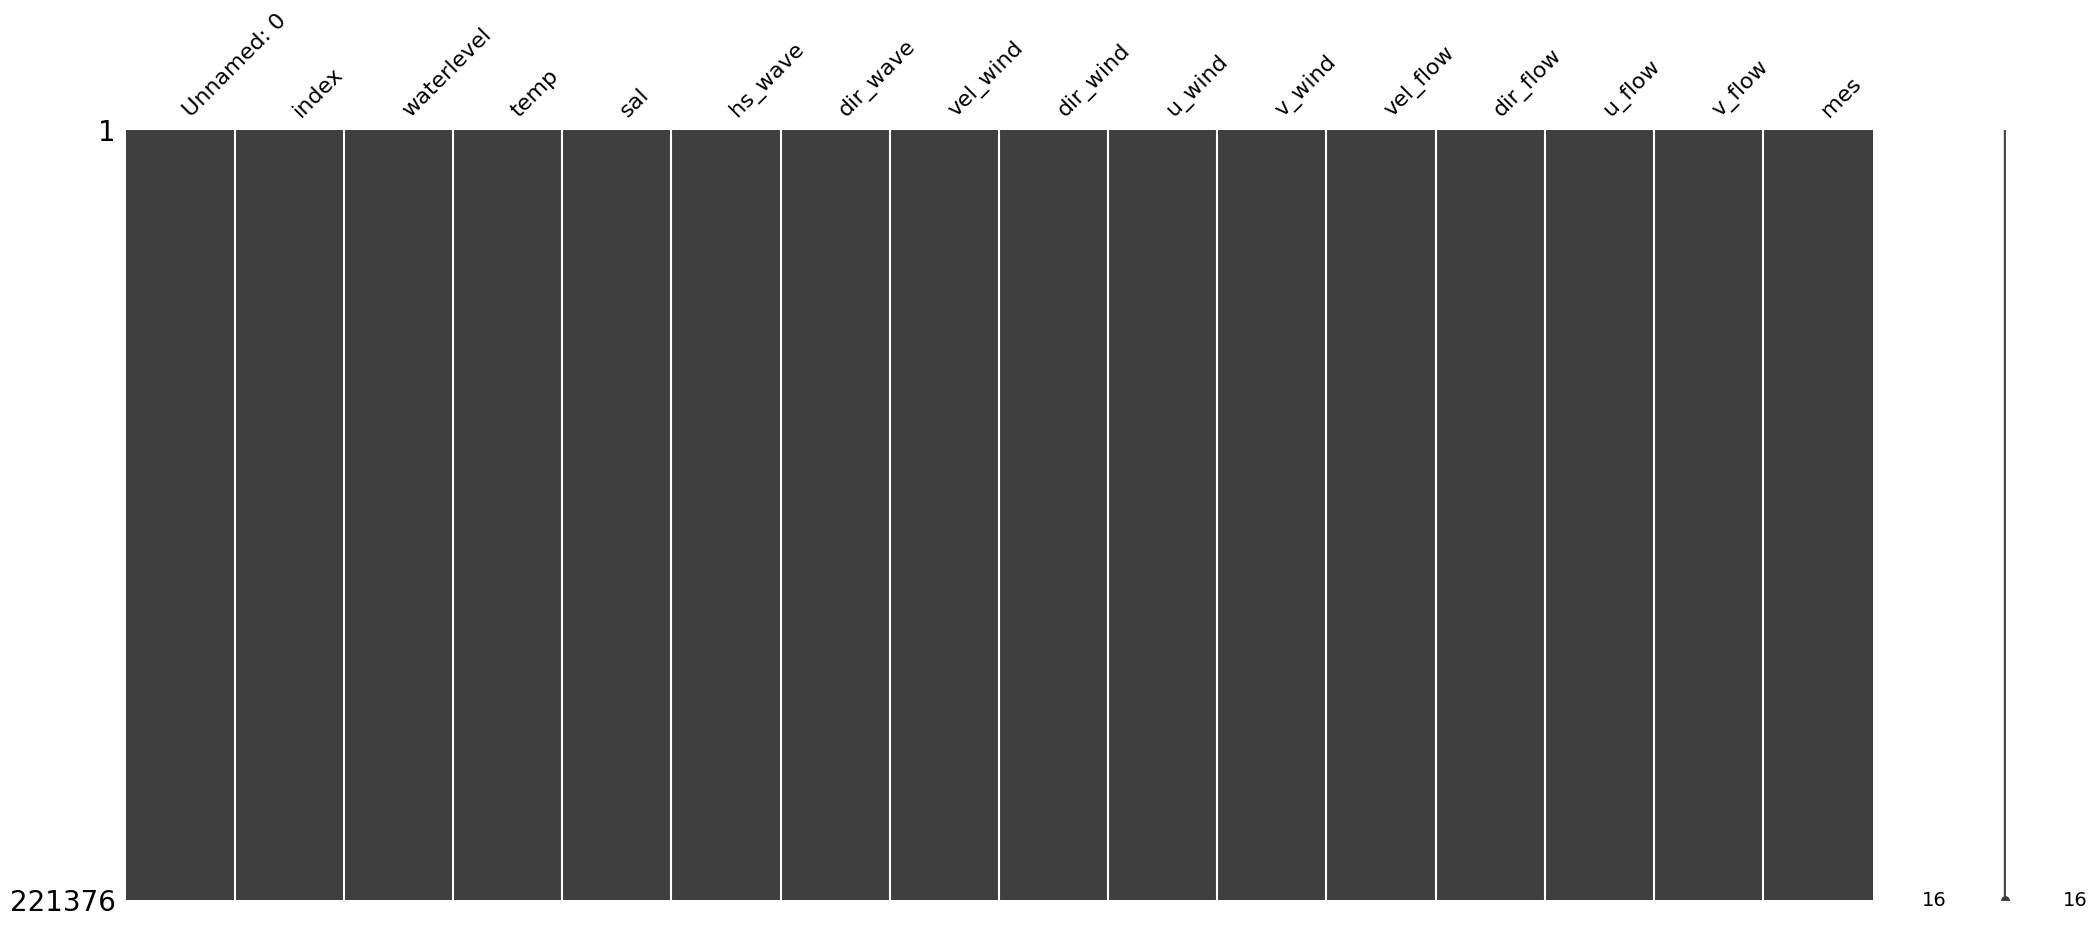

In [7]:
import missingno as msno
msno.matrix(df_db)

In [8]:
df_db.isnull().sum()


Unnamed: 0    0
index         0
waterlevel    0
temp          0
sal           0
hs_wave       0
dir_wave      0
vel_wind      0
dir_wind      0
u_wind        0
v_wind        0
vel_flow      0
dir_flow      0
u_flow        0
v_flow        0
mes           0
dtype: int64

In [9]:
X = df_db[['index','waterlevel', 'temp', 'hs_wave', 'vel_wind']]
Y1 = df_db['vel_flow'] # Obtener la variable predictora Y1
Y2 = df_db['dir_flow'] # Obtener -

# Validación 

Hcaer un split (train (entrenar), test (validar)) de los datos para evaluar el desempeño del modelo. 

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [11]:
from sklearn.model_selection import train_test_split

X_train ,X_test , y_train1,y_test1 = train_test_split(X,Y1, train_size=0.8, random_state=1) # Random state para definir que sea la misma partición (split)
X_train ,X_test , y_train2,y_test2 = train_test_split(X,Y2, train_size=0.8, random_state=1)


print('Dimensiones de la matriz para entrenar:',X_train.shape)
print('Dimensiones de la matriz para validar:',X_test.shape)
print('Dimensiones del vector para entrenar:',y_train1.shape)
print('Dimensiones del vector para validar:',y_test1.shape)
# print('Dimensiones del vector para entrenar:',y_train2.shape)
# print('Dimensiones del vector para validar:',y_test2.shape)

Dimensiones de la matriz para entrenar: (177100, 5)
Dimensiones de la matriz para validar: (44276, 5)
Dimensiones del vector para entrenar: (177100,)
Dimensiones del vector para validar: (44276,)


# K-flod

El método de *K-fold Cross Validation* permite obtener el desempeño del algoritmo con menor varianza que un particion sencilla de *train-test set split*. Este metodo divide lso datos en un número de K subconjuntos (k = 5 ó k = 10). Cada partición es denominada un *fold*. El algoritmo es entonces entrenado con K-1 subconjuntos y un subconjunto es utilizado para validar. Esto es k veces repetido por lo que se obtienen k valores de *score*. El algoritmo es por lo tanto entrenado y evaluado múltiples veces. Como resultado de esta función no se obtiene un modelo, ya que varios modelos son creados internamente, el propósito es sólamente evaluar que tan bien un algoritmo determinado va a generalizar con otros datos diferentes al entrenamiento.

Permite evaluar que tambien un algoritmo generaliza con difernetes arreglos las predicciones de mi modelo 


In [12]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [13]:
# from sklearn.ensemble import RandomForestRegressor

# #----------- Para la magnitud---------------------------
# kfold = KFold(n_splits=5, shuffle= True,random_state=1)
# model = RandomForestRegressor()
# results1 = cross_val_score(model, X_train.iloc[:,1:], y_train1, cv=kfold, scoring='r2') # Obtengo la metrica R2  de cada k-fold (Conjunto de datos)
# # results2 = cross_val_score(model, X_train, y_train2, cv=kfold, scoring='r2') # Obtengo la metrica R2  de cada k-fold (Conjunto de datos)

# print('Resultados para la variable Y1')
# print(results1, '\n' )
# print(results1.mean())
# print(results1.std())

In [14]:
# from sklearn.model_selection import cross_validate
# results_ridge = cross_validate(Ridge(),X.iloc[:,1:],Y1,return_train_score=True,cv=5)

# print('Para Y1**************')
# print(results_ridge)
# test_scores = results_ridge['test_score']
# train_scores = results_ridge['train_score']
# print('Train scores:', np.mean(train_scores))
# print('Test scores:', np.mean(test_scores))


In [15]:
# results_lasso = cross_validate(Lasso(),X.iloc[:,1:],Y1,return_train_score=True,cv=5)

# print('Para Y1**************')
# print(results_lasso)
# test_scores = results_lasso['test_score']
# train_scores = results_lasso['train_score']
# print('Train scores:', np.mean(train_scores))
# print('Test scores:', np.mean(test_scores))

# REGRESION LINEAL 

La Regresión Lineal (RL) asume que las variables predictoras tienen una distribución Gaussiana y que no son correlacionables, por lo tanto es importante en el análisis de datos explorar estas condiciones. Adicionalmente, hay que tener en cuenta que los modelos de RL son modelos geométricos, es decir que se basan en calcular las distancias entre la predicción y los datos reales, por lo tanto es importante normalizar o estandarizar los datos. 

In [16]:
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error,mean_absolute_error

## Procesamiento de datos

In [17]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, Normalizer

In [18]:
st = StandardScaler()
X_stand = st.fit_transform(X.iloc[:,1:]) # Es un arreglo 
X_stand = pd.DataFrame(X_stand, columns= X.iloc[:,1:].columns)
X_stand.insert(0,'index', X.iloc[:,0])
nm = Normalizer()
X_norm = nm.fit_transform(X.iloc[:,1:])
X_norm = pd.DataFrame(X_norm, columns= X.iloc[:,1:].columns)
X_norm.insert(0,'index', X.iloc[:,0])

In [19]:
# Realizar el split de los datos 
X_train_sd ,X_test_sd , y_train1 ,y_test1  = train_test_split(X_stand,Y1, train_size=0.8, random_state=1) # Random state para definir que sea la misma partición (split)
X_train_nm ,X_test_nm , y_train1 ,y_test1  = train_test_split(X_norm,Y1, train_size=0.8, random_state=1) # Random state para definir que sea la misma partición (split)

### Modelo de regresión multivariado

In [20]:
def df_y_ypredic(X, Y, Y_predic):
    x_test_1 = X.copy()
    x_test_1['Y'] = Y
    x_test_1['Y_predic'] = Y_predic
    ind_max = x_test_1['index'].value_counts().index[0]
    x_test_1 = x_test_1[x_test_1['index'] == ind_max]
    return x_test_1

In [21]:
# Apliacicón de OLS a los datos de entrenamiento
import statsmodels.api as sm

lm=sm.OLS(y_train1, X_train.iloc[:,1:]).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:               vel_flow   R-squared (uncentered):                   0.696
Model:                            OLS   Adj. R-squared (uncentered):              0.696
Method:                 Least Squares   F-statistic:                          1.015e+05
Date:                Thu, 08 Dec 2022   Prob (F-statistic):                        0.00
Time:                        10:27:53   Log-Likelihood:                          286.08
No. Observations:              177100   AIC:                                     -564.2
Df Residuals:                  177096   BIC:                                     -523.8
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [22]:
from sklearn.metrics import r2_score
y_pre_test1 = lm.predict(X_test.iloc[:,1:])
r2_test = r2_score(y_test1,y_pre_test1)
print('El r2 representando con los datos de validación es: ',r2_test)

El r2 representando con los datos de validación es:  0.1590315003842443


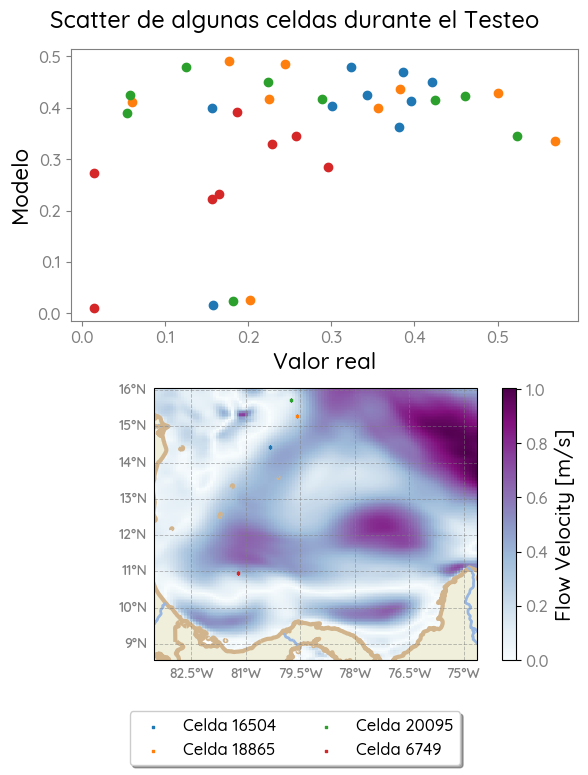

In [23]:
X_andY = X.copy()
X_andY['Y'] = Y1
X_andY['Y_pred'] = lm.predict(X.iloc[:,1:])
mask, mask_pre = mask_ (len_lat, len_lon, 2, X_andY)
index_all = np.arange(0,len_lat*len_lon,1).reshape((len_lat,len_lon))

x_test_1 = X_test.copy()
x_test_1['Y'] = y_test1
x_test_1['Y_predic'] = y_pre_test1
count_ = x_test_1['index'].value_counts()
coun_in = count_.index
index_max = count_.index[0:4]


fig = plt.figure(figsize= (6,7))
ax = fig.add_subplot(2,1,1)
for i in range(len(index_max)):
    ax.scatter(x_test_1[x_test_1['index']==index_max[i]].Y, x_test_1[x_test_1['index']==index_max[i]].Y_predic)
ax.set_xlabel ('Valor real',size=16,fontproperties=prop1)
ax.set_ylabel ('Modelo',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')

ax1 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
# -------Mascara de cartopy---------------
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
ax1.add_feature(cf.LAND)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
cb=plt.colorbar(pc,  ax=ax1)
for i in range(len(index_max)):
    ax1.scatter(lon[np.where(index_all == index_max[i])[1][0]], lat[np.where(index_all == index_max[i])[0][0]], marker = 's',label = 'Celda '+str(index_max[i]), s = 3)

ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.set_ylabel ('Indicador y',size=16,fontproperties=prop1)
ax1.set_xlabel ('Indicador x',size=16,fontproperties=prop1)


cb.set_label('Flow Velocity [m/s]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=12)

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}

_= fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True, ncol=2, fontsize = 10,prop=prop1)
fig.suptitle('Scatter de algunas celdas durante el Testeo',size=17,fontproperties=prop1);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

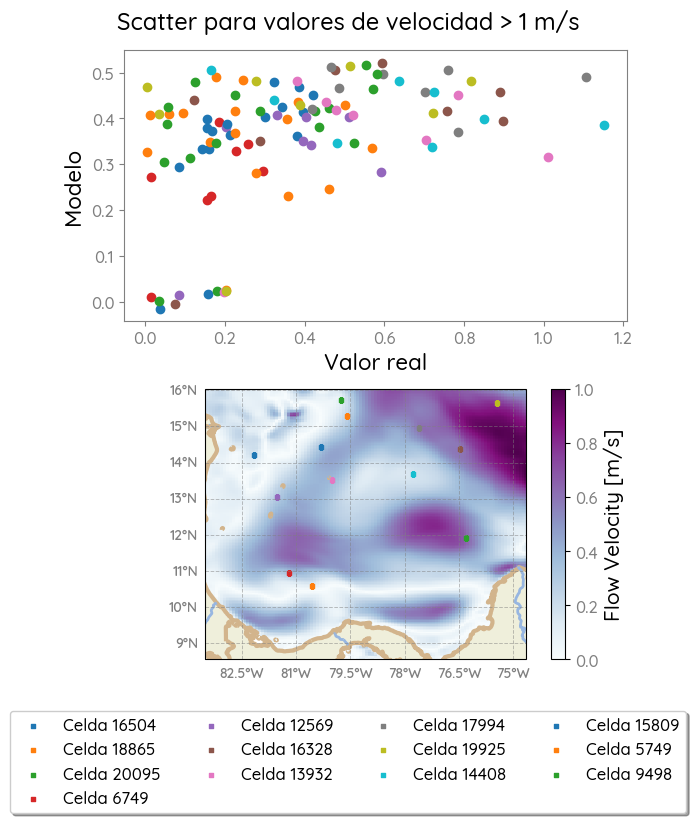

In [24]:
ind_y = np.where(mask>0.99)[0]
ind_x = np.where(mask>0.99)[1]
index_max_vel = [index_all[[ind_y[i]],[ind_x[i]]][0] for i in range(len(ind_y))]
ind_test_max_vel = np.where([coun_in==index_max_vel[i] for i in range(len(index_max_vel))])[0]


fig = plt.figure(figsize= (6,7))
ax = fig.add_subplot(2,1,1)
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax.scatter(x_test_1[x_test_1['index']==index_max].Y, x_test_1[x_test_1['index']==index_max].Y_predic)
ax.set_xlabel ('Valor real',size=16,fontproperties=prop1)
ax.set_ylabel ('Modelo',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')

ax1 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
# -------Mascara de cartopy---------------
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
ax1.add_feature(cf.LAND)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')

pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax1.scatter(lon[np.where(index_all == index_max)[1][0]], lat[np.where(index_all == index_max)[0][0]], marker = 's',label = 'Celda '+str(index_max), s= 5)

ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.set_ylabel ('Indicador y',size=16,fontproperties=prop1)
ax1.set_xlabel ('Indicador x',size=16,fontproperties=prop1)

cb.set_label('Flow Velocity [m/s]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=12)

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}

_= fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
fig.suptitle('Scatter para valores de velocidad > 1 m/s',size=17,fontproperties=prop1);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

In [25]:
# Con intercepto
import statsmodels.formula.api as smf
X_andY = X.copy()
X_andY['vel_flow'] = y_train1
lm=smf.ols(formula='vel_flow ~ waterlevel + temp + hs_wave + vel_wind', data=X_andY).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               vel_flow   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     9044.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:28:58   Log-Likelihood:                 1256.1
No. Observations:              177100   AIC:                            -2502.
Df Residuals:                  177095   BIC:                            -2452.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0876      0.002     44.167      0.0

In [26]:
from sklearn.metrics import r2_score
y_pre_test1 = lm.predict(X_test.iloc[:,1:])
r2_test = r2_score(y_test1,y_pre_test1)
print('El r2 representando con los datos de validación es: ',r2_test)

El r2 representando con los datos de validación es:  0.1685536886564295


In [27]:
model = LinearRegression(fit_intercept = True)
model.fit(X_train.iloc[:,1:],y_train1)


print('R2 - Sklearn:',model.score(X_train.iloc[:,1:],y_train1))
print('Intercepto:',model.intercept_)
results = pd.DataFrame(model.coef_, X_train.iloc[:,1:].columns, columns = ['Coeficientes'])
results


R2 - Sklearn: 0.16961731864357432
Intercepto: 0.08759998763174581


,Coeficientes
waterlevel,0.176366
temp,0.001682
hs_wave,0.118625
vel_wind,0.009266


Se puede observar que con intercepto el bias se vuelve más grande, ya que mi R2 disminuye 0.5 con respecto a no considerar intercepto, el $R^2$ se ajusta más a mi variable. 

**So what’s on with the intercept then?**
As said before, the intercept is the value of our target variable when all our features are zero and our function crosses the y-axis. In Sklearn we can easily include or not the intercept into the equation just by using a hyperparameter of any linear model. And sometimes it can happen, almost by magic, that when we remove the intercept, that makes our model significantly better. However, mind that this only means we’re forcing the line to run through the origin. I.e. we’re saying: when all the coefficients in our equation equal to zero, meaning, all our features are equal to zero, then our target variable will be also zero. And does that make sense? Well, it depends on your business case.

### Estandarizado o normalizado

$X_{nm} = \frac {X- X_{min}}{X_{max}-X{min}}$

Feature scaling is used to bring all values into the range [0,1]. This is also called unity-based normalization. This can be generalized to restrict the range of values in the dataset between any arbitrary points {\displaystyle a}a and {\displaystyle b}b, using for

In [28]:
# Apliacicón de OLS a los datos de entrenamiento
import statsmodels.api as sm

lm=sm.OLS(y_train1, X_train_nm.iloc[:,1:]).fit()
print(lm.summary())

                                 OLS Regression Results                                
Dep. Variable:               vel_flow   R-squared (uncentered):                   0.686
Model:                            OLS   Adj. R-squared (uncentered):              0.686
Method:                 Least Squares   F-statistic:                          9.681e+04
Date:                Thu, 08 Dec 2022   Prob (F-statistic):                        0.00
Time:                        10:28:58   Log-Likelihood:                         -2636.8
No. Observations:              177100   AIC:                                      5282.
Df Residuals:                  177096   BIC:                                      5322.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [29]:
from sklearn.metrics import r2_score
y_pre_test1 = lm.predict(X_test_nm.iloc[:,1:])
r2_test = r2_score(y_test1,y_pre_test1)
print('El r2 representando con los datos de validación es: ',r2_test)

El r2 representando con los datos de validación es:  0.1336087476247212


## Variables categóricas cualitativas 

In [30]:
X_dummies = X.copy()
X_dummies['mes'] = df_db['mes']
X_dummies = pd.get_dummies(X_dummies, prefix='mes_', columns=['mes'])
X_dummies['vel_flow'] = df_db['vel_flow']

X_train_dm ,X_test_dm , y_train1 ,y_test1  = train_test_split(X_dummies,Y1, train_size=0.8, random_state=1) # Random state para definir que sea la misma partición (split)


In [31]:
lm=sm.OLS.from_formula("vel_flow ~ waterlevel + temp + hs_wave + vel_wind + mes__1 + mes__2 + mes__3 + mes__4 + mes__5 + mes__6 + mes__7 + mes__8 + mes__9 + mes__10 + mes__11 + mes__12 -1", X_test_dm.iloc[:,1:]).fit()
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:               vel_flow   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.325
Method:                 Least Squares   F-statistic:                     1421.
Date:                Thu, 08 Dec 2022   Prob (F-statistic):               0.00
Time:                        10:28:58   Log-Likelihood:                 4757.6
No. Observations:               44276   AIC:                            -9483.
Df Residuals:                   44260   BIC:                            -9344.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
waterlevel     0.2540      0.008     30.191      0.0

In [32]:
from sklearn.metrics import r2_score
y_pre_test1 = lm.predict(X_test_dm.iloc[:,1:])
r2_test = r2_score(y_test1,y_pre_test1)
print('El r2 representando con los datos de validación es: ',r2_test)

El r2 representando con los datos de validación es:  0.3249824279585585


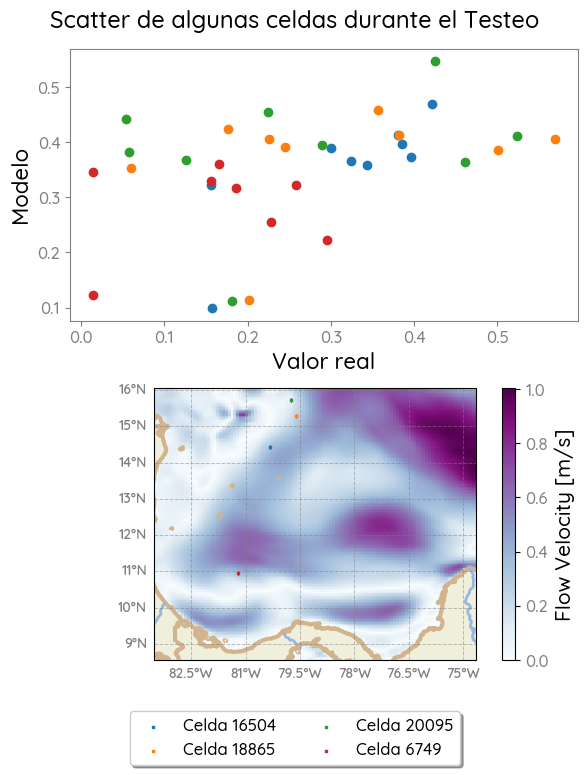

In [33]:
X_andY = X_dummies.copy()
X_andY['Y'] = Y1
X_andY['Y_pred'] = lm.predict(X_dummies.iloc[:,1:])
X_andY['residual'] = Y1 - lm.predict(X_dummies.iloc[:,1:])
mask, mask_pre = mask_ (len_lat, len_lon,2, X_andY)
index_all = np.arange(0,len_lat*len_lon,1).reshape((len_lat,len_lon))

x_test_1 = X_test_dm.copy()
x_test_1['Y'] = y_test1
x_test_1['Y_predic'] = y_pre_test1
count_ = x_test_1['index'].value_counts()
coun_in = count_.index
index_max = count_.index[0:4]


fig = plt.figure(figsize= (6,7))
ax = fig.add_subplot(2,1,1)
for i in range(len(index_max)):
    ax.scatter(x_test_1[x_test_1['index']==index_max[i]].Y, x_test_1[x_test_1['index']==index_max[i]].Y_predic)
ax.set_xlabel ('Valor real',size=16,fontproperties=prop1)
ax.set_ylabel ('Modelo',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')

ax1 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
# -------Mascara de cartopy---------------
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
ax1.add_feature(cf.LAND)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')


pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
cb=plt.colorbar(pc,  ax=ax1)
for i in range(len(index_max)):
    ax1.scatter(lon[np.where(index_all == index_max[i])[1][0]], lat[np.where(index_all == index_max[i])[0][0]], marker = 's',label = 'Celda '+str(index_max[i]), s = 3)

ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.set_ylabel ('Indicador y',size=16,fontproperties=prop1)
ax1.set_xlabel ('Indicador x',size=16,fontproperties=prop1)


cb.set_label('Flow Velocity [m/s]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=12)

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}

_= fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True, ncol=2, fontsize = 10,prop=prop1)
fig.suptitle('Scatter de algunas celdas durante el Testeo',size=17,fontproperties=prop1);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

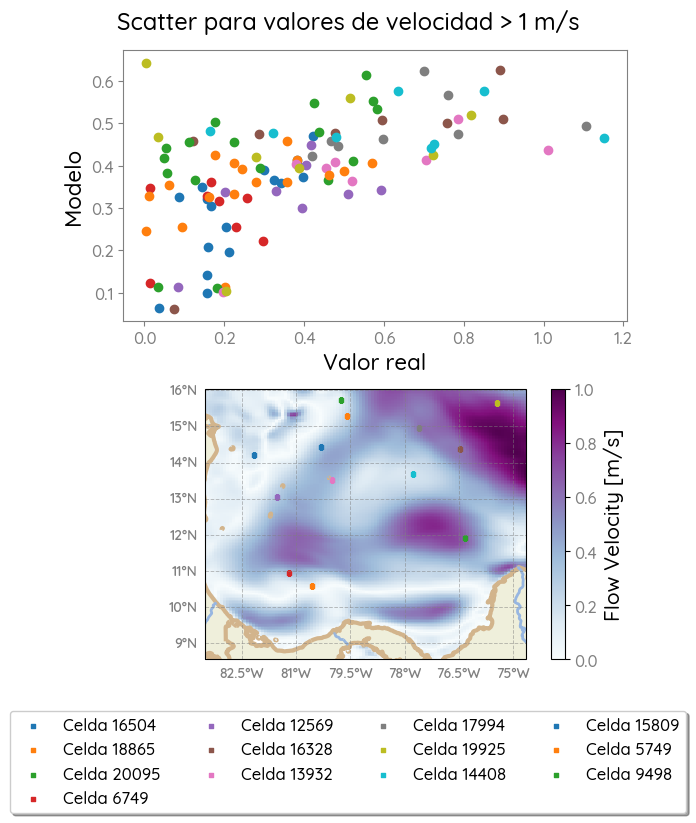

In [34]:
ind_y = np.where(mask>0.99)[0]
ind_x = np.where(mask>0.99)[1]
index_max_vel = [index_all[[ind_y[i]],[ind_x[i]]][0] for i in range(len(ind_y))]
ind_test_max_vel = np.where([coun_in==index_max_vel[i] for i in range(len(index_max_vel))])[0]



fig = plt.figure(figsize= (6,7))
ax = fig.add_subplot(2,1,1)
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax.scatter(x_test_1[x_test_1['index']==index_max].Y, x_test_1[x_test_1['index']==index_max].Y_predic)
ax.set_xlabel ('Valor real',size=16,fontproperties=prop1)
ax.set_ylabel ('Modelo',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')

ax1 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
# -------Mascara de cartopy---------------
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
ax1.add_feature(cf.LAND)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')

pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax1.scatter(lon[np.where(index_all == index_max)[1][0]], lat[np.where(index_all == index_max)[0][0]], marker = 's',label = 'Celda '+str(index_max), s= 5)

ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.set_ylabel ('Indicador y',size=16,fontproperties=prop1)
ax1.set_xlabel ('Indicador x',size=16,fontproperties=prop1)

cb.set_label('Flow Velocity [m/s]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=12)

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}

_= fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
fig.suptitle('Scatter para valores de velocidad > 1 m/s',size=17,fontproperties=prop1);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)


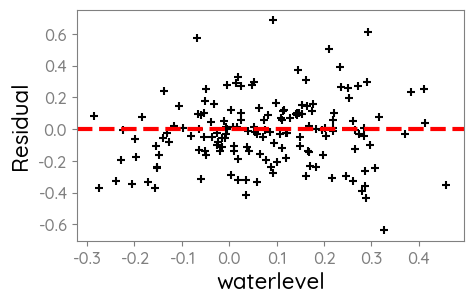

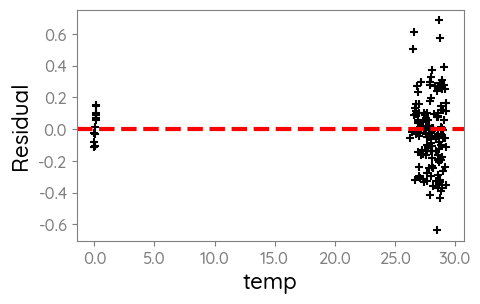

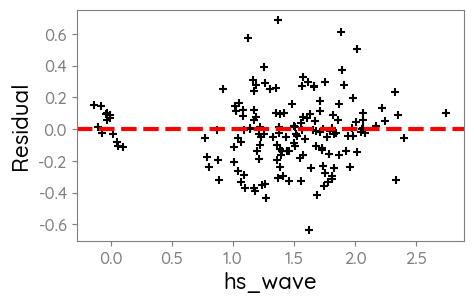

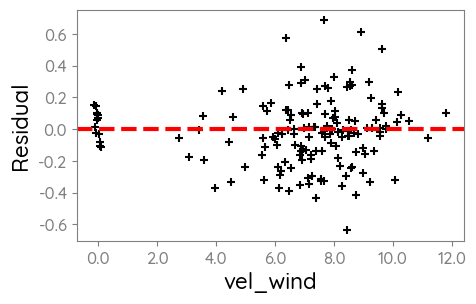

In [35]:
for k in range(1,5,1):
    fig, ax = plt.subplots(figsize= (5,3))
    for i in range(len(ind_test_max_vel)):
        index_max = coun_in[ind_test_max_vel[i]]
        ax.scatter(X_andY[X_andY['index']==index_max].iloc[:,k], X_andY[X_andY['index']==index_max].residual, label = 'Celda '+str(index_max), color = 'k', marker = '+')
    ax.set_ylabel ('Residual',size=16,fontproperties=prop1)
    ax.set_xlabel (str(X_andY[X_andY['index']==index_max].iloc[:,k].name),size=16,fontproperties=prop1)
    ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
    ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    ax.axhline(y=0, color = 'r', linestyle = '--', lw = 3)
    # _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
    #           fancybox=True, shadow=True, ncol=3, fontsize = 10 ,prop=prop1)

Text(0.5, 1.0, 'Fitted vs. residuals plot')

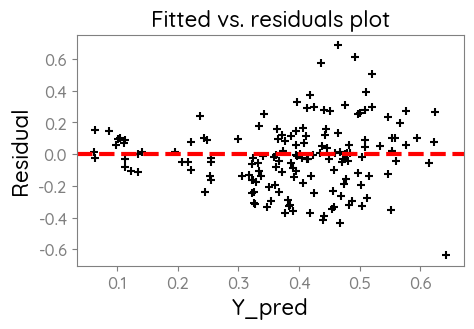

In [36]:
fig, ax = plt.subplots(figsize= (5,3))
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax.scatter(X_andY[X_andY['index']==index_max].iloc[:,-2], X_andY[X_andY['index']==index_max].residual, label = 'Celda '+str(index_max), color = 'k', marker = '+')
ax.set_ylabel ('Residual',size=16,fontproperties=prop1)
ax.set_xlabel (str(X_andY[X_andY['index']==index_max].iloc[:,-2].name),size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')
ax.axhline(y=0, color = 'r', linestyle = '--', lw = 3);
ax.set_title("Fitted vs. residuals plot",size=16,fontproperties=prop1)
# _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
#           fancybox=True, shadow=True, ncol=3, fontsize = 10 ,prop=prop1)

Viola los principios del modelo de regresión lienal: 
- Tener una varianza constante (homoestacicidad)
- Ser aproximadamente normalmente distribuido
- Ser independiente del otro. 

Cuando se detecta heterocedasticidad en los residuos de un modelo, sugiere que el modelo está mal especificado (es decir, en algún sentido incorrecto). Las posibles causas de la heteroscedasticidad incluyen: Asumir incorrectamente relaciones lineales en los modelos Suposiciones de distribución incorrectas (p. ej., usar regresión lineal cuando la regresión de Poisson sería apropiada) Modelos que funcionan mejor para algunos subgrupos que otros (p. ej., un modelo que funciona bien para las mujeres pero mal para los hombres exhibirá heteroscedasticidad) La existencia de autocorrelación significa que los cálculos estándar de los errores estándar y, en consecuencia, los valores de p, son engañosos.

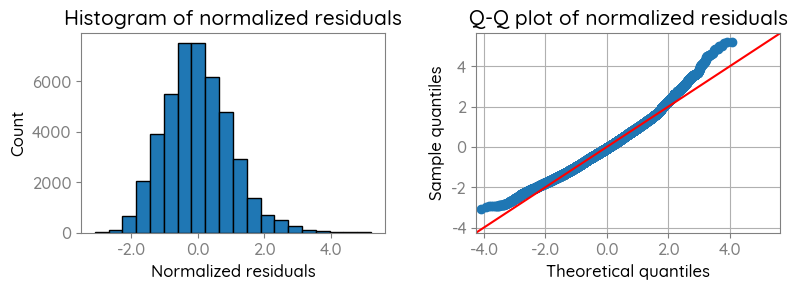

In [37]:
from statsmodels.graphics.gofplots import qqplot

fig, axs = plt.subplots(1,2,figsize=(8,3))
ax = axs[0]
ax.hist(lm.resid_pearson,bins=20,edgecolor='k')
ax.set_ylabel('Count',size=12,fontproperties=prop1)
ax.set_xlabel('Normalized residuals',size=12,fontproperties=prop1)
ax.set_title("Histogram of normalized residuals",size=15,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')

ax1 = axs[1]
fig=qqplot(lm.resid_pearson,line='45',fit='True', ax=ax1)
ax1.set_xlabel("Theoretical quantiles",size=12,fontproperties=prop1)
ax1.set_ylabel("Sample quantiles",size=12,fontproperties=prop1)
ax1.set_title("Q-Q plot of normalized residuals",size=15,fontproperties=prop1)
ax1.grid(True)
ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')

fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.2)


Apesar de que se presenta una distribución casi normal de los residuales, en los extremos principalmente derech, es posible que haya outliers 

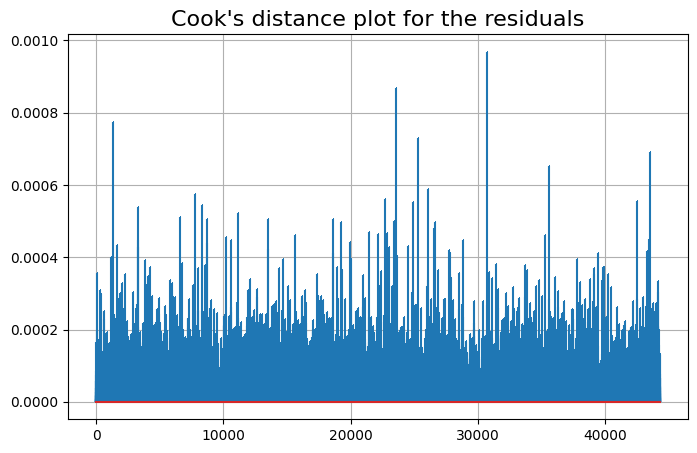

In [38]:
from statsmodels.stats.outliers_influence import OLSInfluence as influence
inf=influence(lm)
(c, p) = inf.cooks_distance
plt.figure(figsize=(8,5))
plt.title("Cook's distance plot for the residuals",fontsize=16)
plt.stem(np.arange(len(c)), c, markerfmt=",")
plt.grid(True)
plt.show()

## Evaluación de la regresión seleccionada

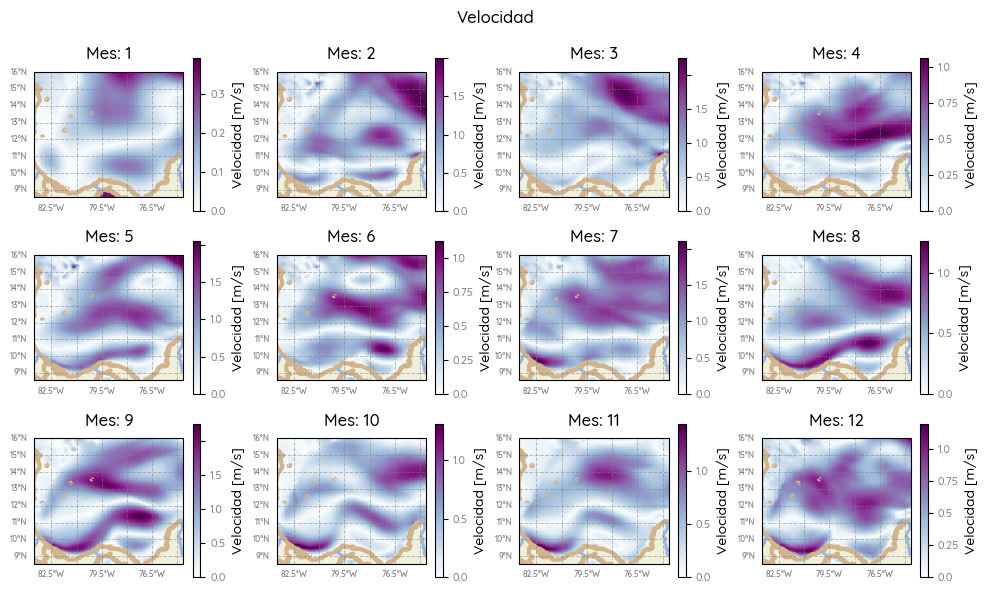

In [39]:
fig = plt.figure(figsize = [10,6])


c = 1
for  i in range(1,13,1):
    ax1 = fig.add_subplot(3,4,i, projection=ccrs.PlateCarree())
    mask, mask_pre = mask_ (len_lat, len_lon,c, X_andY)
    y_residual = mask-mask_pre
    # -------Mascara de cartopy---------------
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
    ax1.add_feature(cf.LAND)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
    ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')



    # pc = ax1.contourf(lon,lat,mask, cmap = cm.cool)
    pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
    cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    ax1.set_title('Mes: '+ str(c),size=12,fontproperties=prop1);
    cb.set_label('Velocidad [m/s]',size=10,fontproperties=prop1)
    cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=8)
    c = c+1
    # if j ==0: 
    #     ax1.set_ylabel ('Indicador y',size=10,fontproperties=prop1, color = 'gray')
    # if i ==2:
    #     ax1.set_xlabel ('Indicador x',size=10,fontproperties=prop1, color = 'gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 6, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
    gl.xlabel_style = {'size': 6, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}



fig.suptitle('Velocidad',size=12,fontproperties=prop1)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.2)

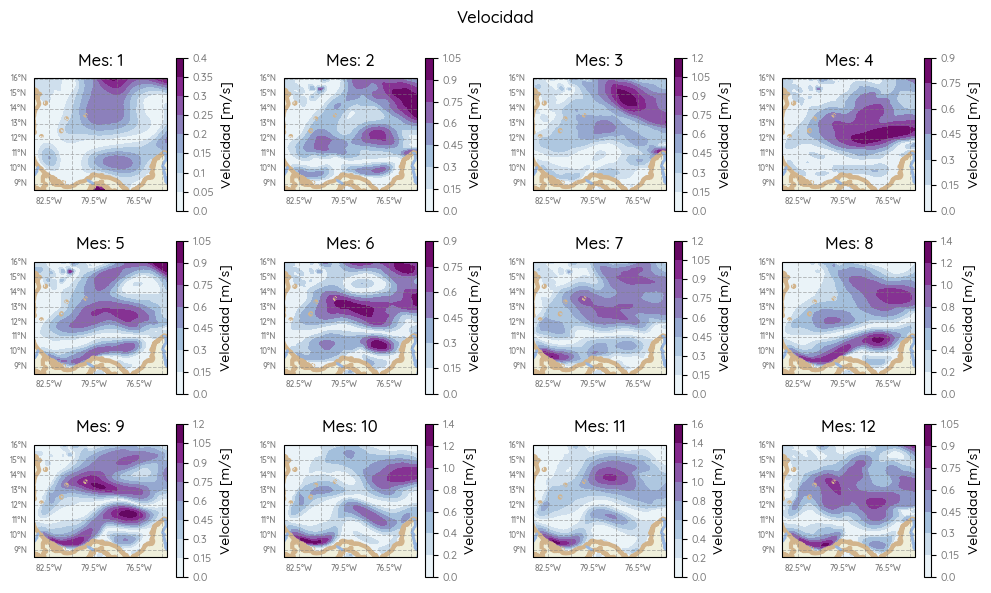

In [40]:
fig = plt.figure(figsize = [10,6])


c = 1
for  i in range(1,13,1):
    ax1 = fig.add_subplot(3,4,i, projection=ccrs.PlateCarree())
    mask, mask_pre = mask_ (len_lat, len_lon,c, X_andY)
    y_residual = mask-mask_pre
    # -------Mascara de cartopy---------------
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
    ax1.add_feature(cf.LAND)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
    ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')



    pc = ax1.contourf(lon,lat,mask, cmap = cm.BuPu)
    # pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
    cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    ax1.set_title('Mes: '+ str(c),size=12,fontproperties=prop1);
    cb.set_label('Velocidad [m/s]',size=10,fontproperties=prop1)
    cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=8)
    c = c+1
    # if j ==0: 
    #     ax1.set_ylabel ('Indicador y',size=10,fontproperties=prop1, color = 'gray')
    # if i ==2:
    #     ax1.set_xlabel ('Indicador x',size=10,fontproperties=prop1, color = 'gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 6, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
    gl.xlabel_style = {'size': 6, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}



fig.suptitle('Velocidad',size=12,fontproperties=prop1)
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.2)



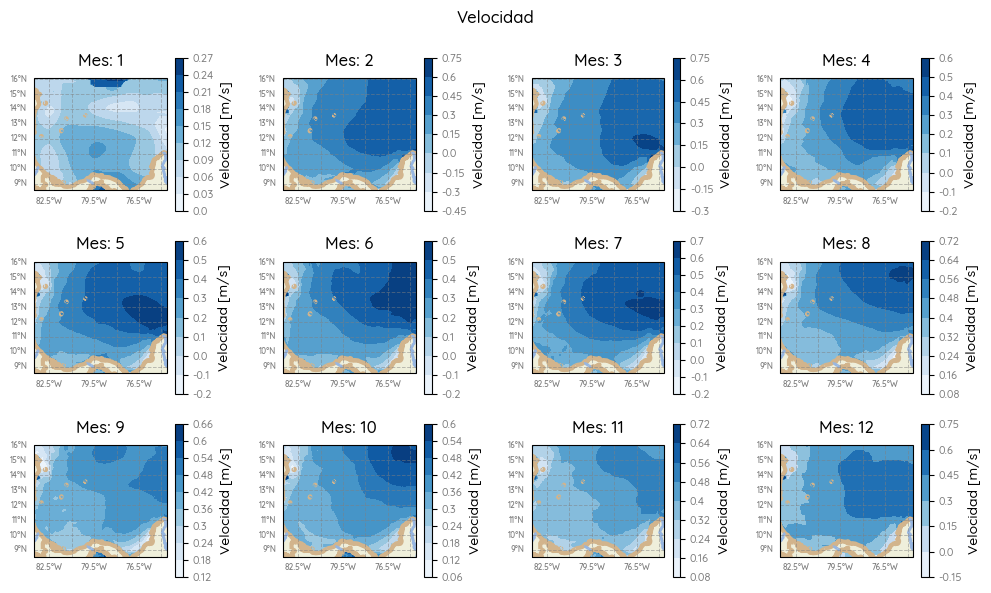

In [41]:
fig = plt.figure(figsize = [10,6])


c = 1
for  i in range(1,13,1):
    ax1 = fig.add_subplot(3,4,i, projection=ccrs.PlateCarree())
    mask, mask_pre = mask_ (len_lat, len_lon,c, X_andY)
    y_residual = mask-mask_pre
    # -------Mascara de cartopy---------------
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
    ax1.add_feature(cf.LAND)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
    ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')



    pc = ax1.contourf(lon,lat,mask_pre, cmap = cm.Blues)
    # pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
    cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    ax1.set_title('Mes: '+ str(c),size=12,fontproperties=prop1);
    cb.set_label('Velocidad [m/s]',size=10,fontproperties=prop1)
    cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=8)
    c = c+1
    # if j ==0: 
    #     ax1.set_ylabel ('Indicador y',size=10,fontproperties=prop1, color = 'gray')
    # if i ==2:
    #     ax1.set_xlabel ('Indicador x',size=10,fontproperties=prop1, color = 'gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 6, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
    gl.xlabel_style = {'size': 6, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}



fig.suptitle('Velocidad',size=12,fontproperties=prop1)
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.2)

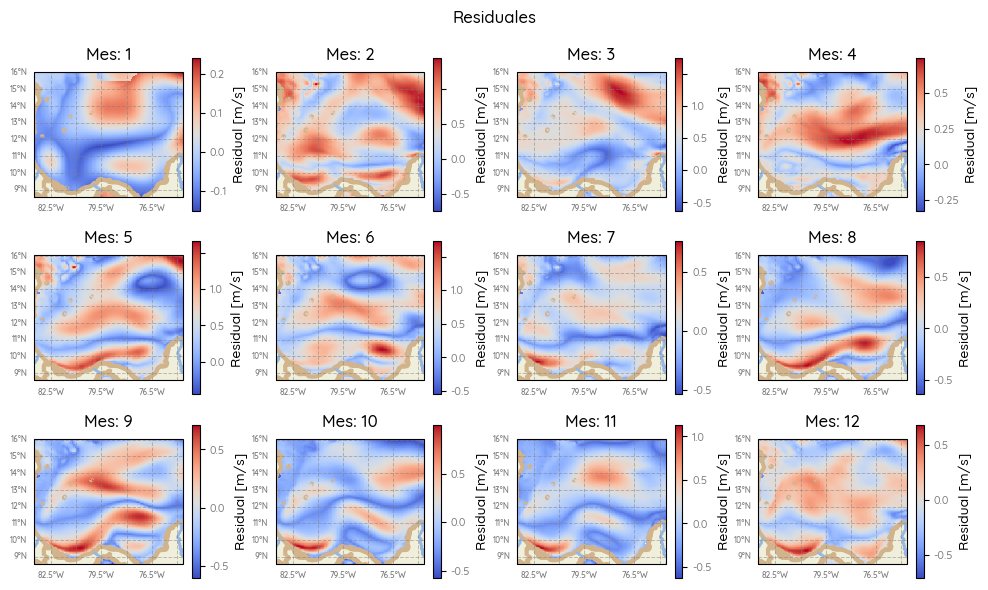

In [42]:
fig = plt.figure(figsize = [10,6])


c = 1
for  i in range(1,13,1):
    ax1 = fig.add_subplot(3,4,i, projection=ccrs.PlateCarree())
    mask, mask_pre = mask_ (len_lat, len_lon,c, X_andY)
    y_residual = mask-mask_pre
    # -------Mascara de cartopy---------------
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
    ax1.add_feature(cf.LAND)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
    ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')



    # pc = ax1.contourf(lon,lat,mask, cmap = cm.cool)
    pc = ax1.pcolor(lon, lat, y_residual, cmap = cm.coolwarm)
    cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    ax1.set_title('Mes: '+ str(c),size=12,fontproperties=prop1);
    cb.set_label('Residual [m/s]',size=10,fontproperties=prop1)
    cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=8)
    c = c+1
    # if j ==0: 
    #     ax1.set_ylabel ('Indicador y',size=10,fontproperties=prop1, color = 'gray')
    # if i ==2:
    #     ax1.set_xlabel ('Indicador x',size=10,fontproperties=prop1, color = 'gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 6, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
    gl.xlabel_style = {'size': 6, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}



fig.suptitle('Residuales',size=12,fontproperties=prop1)
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.2)

## Penalización

In [43]:
# RandomSearch
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_grid = {'alpha': uniform()}
rsearch = RandomizedSearchCV(estimator=Lasso(fit_intercept = False), param_distributions=param_grid, n_iter=100, random_state=1)
rsearch.fit(X_train_sd.iloc[:,1:], y_train1)
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)


-1.5969334930207655
0.00011437481734488664


In [44]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_grid = {'alpha': uniform()}
rsearch = RandomizedSearchCV(estimator=Ridge(fit_intercept = False), param_distributions=param_grid, n_iter=100, random_state=1)
rsearch.fit(X_train_sd.iloc[:,1:], y_train1)
print(rsearch.best_score_)
print(rsearch.best_estimator_.alpha)

-1.596933141314826
0.9888610889064947


# KNN

Lazy learning: KNN no genera un modelo fruto del aprendizaje con datos de entrenamiento, sino que el aprendizaje sucede en el mismo momento en el que se prueban los datos de test.

Basado en Instancia: Esto quiere decir que nuestro algoritmo no aprende explícitamente un modelo (como por ejemplo en Regresión Logística o árboles de decisión). En cambio memoriza las instancias de entrenamiento que son usadas como base de conocimiento para la fase de predicción.

Modelo supervisado: A diferencia de K-means, que es un algoritmo no supervisado y donde la «K» significa la cantidad de grupos (clusters) que deseamos clasificar, en K-Nearest Neighbor la «K» significa la cantidad de «puntos vecinos» que tenemos en cuenta en las cercanías para clasificar los «n» grupos -que ya se conocen de antemano, pues es un algoritmo supervisado.

Nonparametric: KNN makes no assumptions about the functional form of the problem being solved. As such KNN is referred to as a nonparametric machine learning algorithm

## Resultados generales

In [73]:
# Validación curzada con shufflesplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit

kfold = ShuffleSplit(n_splits=5)
model = KNeighborsRegressor()
results = cross_val_score(model, X_train.iloc[:,1:], y_train1, cv=kfold)
print(results.mean())
print(results.std())

0.9129901863252652
0.0032970304178354636


## Selección de hiperparametros

In [74]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_validate

# Validación cruzada a partir de Kfold
results=cross_validate(KNeighborsRegressor(), X_train.iloc[:,1:], y_train1, return_train_score=True, cv=5)
results

{'fit_time': array([0.19835162, 0.18197632, 0.14621973, 0.14228535, 0.13695002]),
 'score_time': array([0.39645267, 0.28215361, 0.27095723, 0.261971  , 0.27937818]),
 'test_score': array([0.90687463, 0.91012153, 0.90497518, 0.91268492, 0.90882351]),
 'train_score': array([0.94393763, 0.94265612, 0.94363644, 0.94285257, 0.94350868])}

In [47]:
# Buscada de los vecinos 
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

k_neighbors = np.arange(2,115,10)
param_grid = {'n_neighbors': k_neighbors}
rsearch = RandomizedSearchCV(estimator=KNeighborsRegressor(), param_distributions=param_grid, n_iter=100, random_state=1)
rsearch.fit(X_train.iloc[:,1:], y_train1)
print('Mejor R2',rsearch.best_score_)
print('Mejor estimador', rsearch.best_estimator_.n_neighbors)

Mejor R2 0.9126437799970694
Mejor estimador 2


In [48]:

# from sklearn.model_selection import validation_curve
# fig, axs = plt.subplots(3,4,figsize = (12,6) ,sharex = True)
# c = 1
# for i in range(0,3,1):
#         for j in range(0,4,1):
#                 train_scores, test_scores = validation_curve(KNeighborsRegressor(), X[df_db.mes==c].iloc[:,1:], Y1[df_db.mes==c], param_name='n_neighbors', param_range=k_neighbors, cv=6)
                
#                 ax=axs[i,j]
#                 np.mean(train_scores,axis=1), np.mean(test_scores,axis=1)
#                 ax.set_title("Mes " + str(c),size = 10,fontproperties=prop1, fontweight ="bold")    
#                 if c == 1:
#                         ax.plot(k_neighbors,np.mean(train_scores,axis=1),label="Entrenamiento", marker= 'o',ms = 3)
#                         ax.plot(k_neighbors,np.mean(test_scores,axis=1),label="Validación", marker= 'o',ms = 3)
#                 else: 
#                         ax.plot(k_neighbors,np.mean(train_scores,axis=1), marker= 'o',ms = 3)
#                         ax.plot(k_neighbors,np.mean(test_scores,axis=1), marker= 'o',ms = 3)
#                 ax.set_yticklabels(ax.get_yticks().round(2), fontproperties=prop1,color='gray',size = 10)
#                 ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 10)
#                 if i == 2:
#                         ax.set_xlabel("k", size = 11,fontproperties=prop2, fontweight ="bold", color = 'gray')
#                 if j == 0:
#                         ax.set_ylabel("Score", size = 11,fontproperties=prop2, fontweight ="bold", color = 'gray')
#                 # ax.set_xticks(np.arange(49),k)
#                 ax.spines['left'].set_color('gray')
#                 ax.spines['right'].set_color('gray')
#                 ax.spines['bottom'].set_color('gray')
#                 ax.spines['top'].set_color('gray')
#                 ax.tick_params('y', colors='tab:gray')
#                 ax.tick_params('x', colors='tab:gray')
#                 ax.grid(True);
#                 c= c+1

# _= fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.007),
#         fancybox=True, shadow=True, ncol=2, fontsize = 10,prop=prop1)
# fig.suptitle('Curvas de validación (KNeighbors)',size=12,fontproperties=prop1)
# fig.tight_layout()
# plt.subplots_adjust(wspace=0.3)
# plt.subplots_adjust(hspace=0.17)

## Aplicación del modelo

In [49]:
import math
model = KNeighborsRegressor(n_neighbors=2)
# Función de ajuste
fun_ajuste = model.fit(X_train.iloc[:,1:],y_train1)

# Score del entrenamiento
score=model.score(X_train.iloc[:,1:],y_train1)
print('R2 del entrenamiento:',score)

# Score del test
y_pred_test_knn = model.predict(X_test.iloc[:,1:])
r2_test = r2_score(y_test1,y_pred_test_knn)
print('El R2 de la validación: ',r2_test)

mse =mean_squared_error(y_test1, y_pred_test_knn)
print("Mean Squared Error:",mse)
rmse = math.sqrt(mse)
print("Root Mean Squared Error:", rmse)

R2 del entrenamiento: 0.9767871276795833
El R2 de la validación:  0.9217751532563562
Mean Squared Error: 0.005472961625236615
Root Mean Squared Error: 0.073979467592276


In [50]:
# Validación cruzada con el numero de vecinos econtrados 
results=cross_validate(KNeighborsRegressor(n_neighbors=2), X.iloc[:,1:], Y1, return_train_score=True, cv=5)
results

{'fit_time': array([0.16945815, 0.16142797, 0.17029238, 0.14228129, 0.14084339]),
 'score_time': array([0.3230989 , 0.3850472 , 0.42709351, 0.38610864, 0.42261124]),
 'test_score': array([ 0.0911351 , -0.10381071, -0.50857064, -0.78432587, -0.41246546]),
 'train_score': array([0.97574272, 0.97745881, 0.98080827, 0.97963897, 0.98209444])}

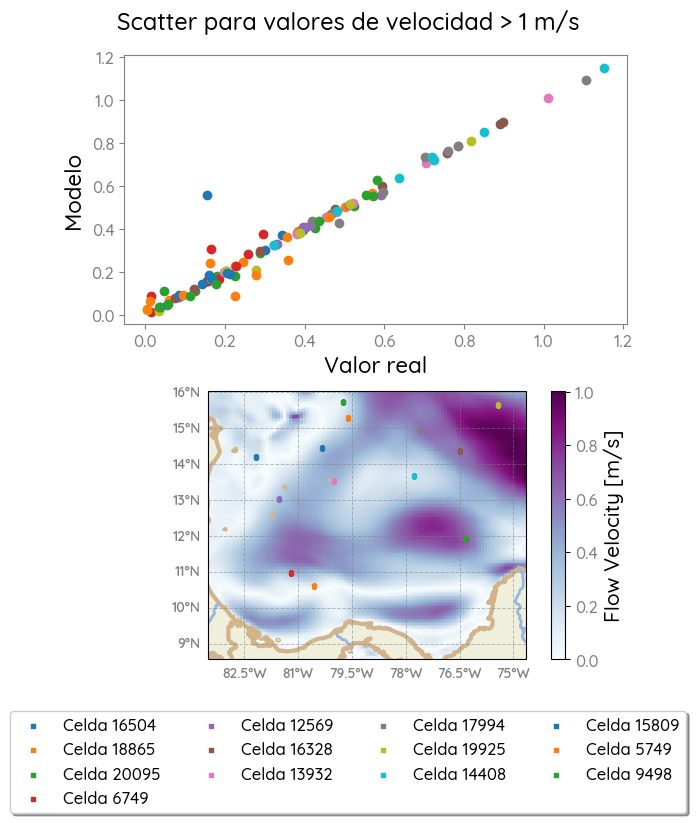

In [51]:
X_andY = X.copy()
X_andY['Y'] = Y1
X_andY['Y_pred'] = model.predict(X.iloc[:,1:])
# X_andY['residual'] = Y1 - lm.predict(X.iloc[:,1:])
mask, mask_pre = mask_ (len_lat, len_lon,2, X_andY)
index_all = np.arange(0,len_lat*len_lon,1).reshape((len_lat,len_lon))

x_test_1 = X_test.copy()
x_test_1['Y'] = y_test1
x_test_1['Y_predic'] = y_pred_test_knn
count_ = x_test_1['index'].value_counts()
coun_in = count_.index
index_max = count_.index[0:4]

ind_y = np.where(mask>0.99)[0]
ind_x = np.where(mask>0.99)[1]
index_max_vel = [index_all[[ind_y[i]],[ind_x[i]]][0] for i in range(len(ind_y))]
ind_test_max_vel = np.where([coun_in==index_max_vel[i] for i in range(len(index_max_vel))])[0]

fig = plt.figure(figsize= (6,7))
ax = fig.add_subplot(2,1,1)
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax.scatter(x_test_1[x_test_1['index']==index_max].Y, x_test_1[x_test_1['index']==index_max].Y_predic)
ax.set_xlabel ('Valor real',size=16,fontproperties=prop1)
ax.set_ylabel ('Modelo',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')

ax1 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
# -------Mascara de cartopy---------------
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
ax1.add_feature(cf.LAND)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')

pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax1.scatter(lon[np.where(index_all == index_max)[1][0]], lat[np.where(index_all == index_max)[0][0]], marker = 's',label = 'Celda '+str(index_max), s= 5)

ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.set_ylabel ('Indicador y',size=16,fontproperties=prop1)
ax1.set_xlabel ('Indicador x',size=16,fontproperties=prop1)

cb.set_label('Flow Velocity [m/s]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=12)

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}

_= fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
fig.suptitle('Scatter para valores de velocidad > 1 m/s',size=17,fontproperties=prop1);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

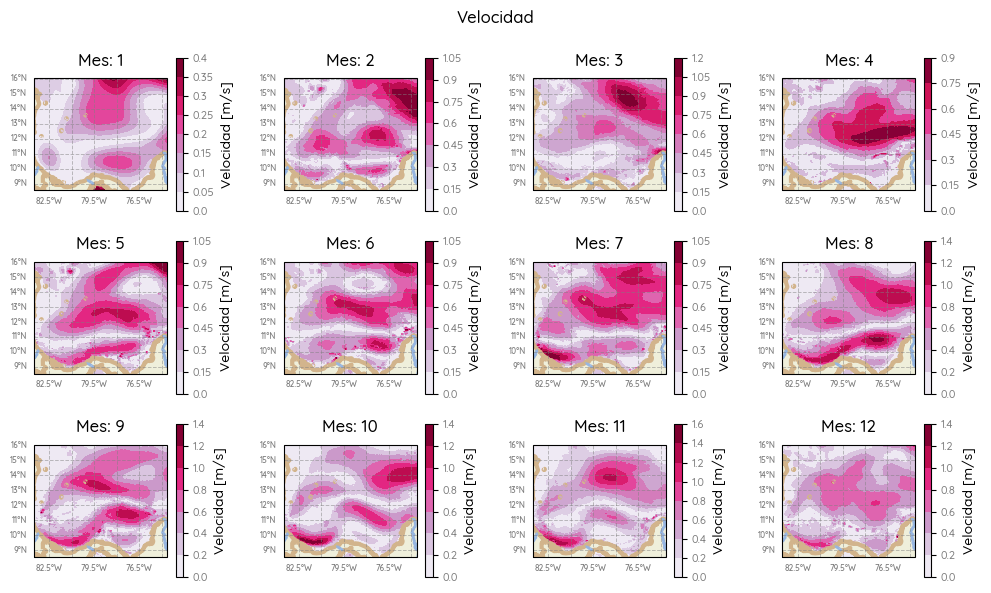

In [52]:
fig = plt.figure(figsize = [10,6])


c = 1
for  i in range(1,13,1):
    ax1 = fig.add_subplot(3,4,i, projection=ccrs.PlateCarree())
    mask, mask_pre = mask_ (len_lat, len_lon,c, X_andY)
    y_residual = mask-mask_pre
    # -------Mascara de cartopy---------------
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
    ax1.add_feature(cf.LAND)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
    ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')



    pc = ax1.contourf(lon,lat,mask_pre, cmap = cm.PuRd)
    # pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
    cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    ax1.set_title('Mes: '+ str(c),size=12,fontproperties=prop1);
    cb.set_label('Velocidad [m/s]',size=10,fontproperties=prop1)
    cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=8)
    c = c+1
    # if j ==0: 
    #     ax1.set_ylabel ('Indicador y',size=10,fontproperties=prop1, color = 'gray')
    # if i ==2:
    #     ax1.set_xlabel ('Indicador x',size=10,fontproperties=prop1, color = 'gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 6, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
    gl.xlabel_style = {'size': 6, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}



fig.suptitle('Velocidad',size=12,fontproperties=prop1)
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.2)

# SVM

Epsilon-Support Vector Regression.

The free parameters in the model are C and epsilon.

The implementation is based on libsvm. The fit time complexity is more than quadratic with the number of samples which makes it hard to scale to datasets with more than a couple of 10000 samples. For large datasets consider using LinearSVR or SGDRegressor instead, possibly after a Nystroem transformer.

- Se elige linear suppor vector dado que se tiene una muestra grande de datos, luego: 
Regresión de vectores de soporte lineal. Similar a SVR con el parámetro kernel='linear', pero implementado en términos de liblinear en lugar de libsvm, por lo que tiene más flexibilidad en la elección de penalizaciones y funciones de pérdida y debería escalar mejor a un gran número de muestras.

In [72]:
from sklearn.svm import LinearSVR
kfold = ShuffleSplit(n_splits=5)
model = LinearSVR()
results = cross_val_score(model, X_train_sd.iloc[:,1:], y_train1, cv=kfold)
print(results.mean())
print(results.std())

0.13139623741992826
0.003890282454871649


In [54]:
# Selección de hiperparámetros
# from sklearn.svm import LinearSVR
# c_params = np.arange(1,100,10)
# param_grid = {'C': c_params}
# rsearch = RandomizedSearchCV(estimator=LinearSVR(), param_distributions=param_grid, n_iter=100, random_state=1)
# rsearch.fit(X_train.iloc[:,1:], y_train1)
# print('Mejor R2',rsearch.best_score_)
# print('Mejor estimador', rsearch.best_estimator_.C)

In [55]:
# from sklearn.svm import LinearSVR
# c_params = np.arange(1,100,10)
# param_grid = {'C': c_params}
# rsearch = RandomizedSearchCV(estimator=LinearSVR(), param_distributions=param_grid, n_iter=100, random_state=1)
# rsearch.fit(X_train_sd.iloc[:,1:], y_train1)
# print('Mejor R2',rsearch.best_score_)
# print('Mejor estimador', rsearch.best_estimator_.C)

KeyboardInterrupt: 

In [ ]:
from sklearn.svm import LinearSVR

svr_lin = LinearSVR(C=1)
# svr_lin = SVR(kernel="linear", C=1, gamma="auto")
y_lin = svr_lin.fit(X_train_sd.iloc[:,1:],y_train1)

# Score del entrenamiento
score=svr_lin.score(X_train_sd.iloc[:,1:],y_train1)
print('R2 del entrenamiento:',score)


# Score del test
y_pred_test_svr = svr_lin.predict(X_test_sd.iloc[:,1:])
r2_test = r2_score(y_test1,y_pred_test_svr)
print('El R2 de la validación: ',r2_test)

R2 del entrenamiento: 0.1317700905814193
El R2 de la validación:  0.1319492535381498


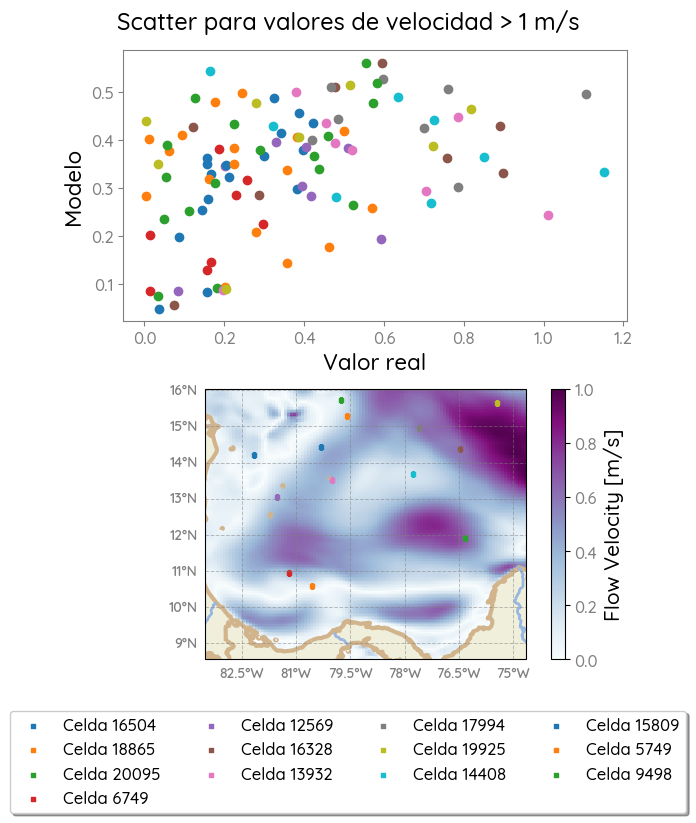

In [ ]:
X_andY = X.copy()
X_andY['Y'] = Y1
X_andY['Y_pred'] = svr_lin.predict(X.iloc[:,1:])
# X_andY['residual'] = Y1 - lm.predict(X.iloc[:,1:])
mask, mask_pre = mask_ (len_lat, len_lon,2, X_andY)
index_all = np.arange(0,len_lat*len_lon,1).reshape((len_lat,len_lon))

x_test_1 = X_test.copy()
x_test_1['Y'] = y_test1
x_test_1['Y_predic'] = y_pred_test_svr
count_ = x_test_1['index'].value_counts()
coun_in = count_.index
index_max = count_.index[0:4]

ind_y = np.where(mask>0.99)[0]
ind_x = np.where(mask>0.99)[1]
index_max_vel = [index_all[[ind_y[i]],[ind_x[i]]][0] for i in range(len(ind_y))]
ind_test_max_vel = np.where([coun_in==index_max_vel[i] for i in range(len(index_max_vel))])[0]

fig = plt.figure(figsize= (6,7))
ax = fig.add_subplot(2,1,1)
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax.scatter(x_test_1[x_test_1['index']==index_max].Y, x_test_1[x_test_1['index']==index_max].Y_predic)
ax.set_xlabel ('Valor real',size=16,fontproperties=prop1)
ax.set_ylabel ('Modelo',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')

ax1 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
# -------Mascara de cartopy---------------
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
ax1.add_feature(cf.LAND)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')

pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax1.scatter(lon[np.where(index_all == index_max)[1][0]], lat[np.where(index_all == index_max)[0][0]], marker = 's',label = 'Celda '+str(index_max), s= 5)

ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.set_ylabel ('Indicador y',size=16,fontproperties=prop1)
ax1.set_xlabel ('Indicador x',size=16,fontproperties=prop1)

cb.set_label('Flow Velocity [m/s]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=12)

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}

_= fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
fig.suptitle('Scatter para valores de velocidad > 1 m/s',size=17,fontproperties=prop1);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

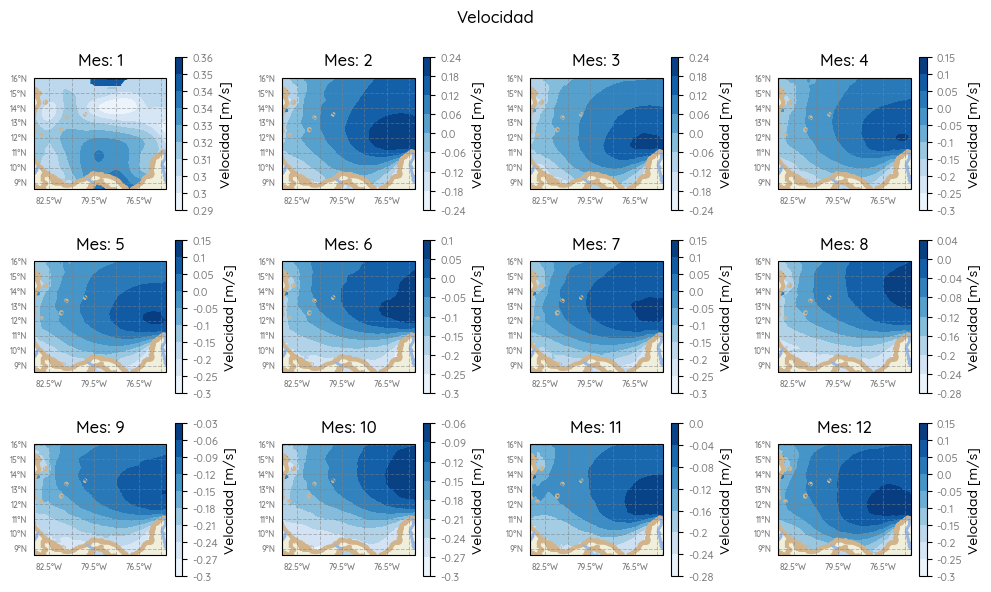

In [ ]:
fig = plt.figure(figsize = [10,6])


c = 1
for  i in range(1,13,1):
    ax1 = fig.add_subplot(3,4,i, projection=ccrs.PlateCarree())
    mask, mask_pre = mask_ (len_lat, len_lon,c, X_andY)
    y_residual = mask-mask_pre
    # -------Mascara de cartopy---------------
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
    ax1.add_feature(cf.LAND)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
    ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')



    pc = ax1.contourf(lon,lat,mask_pre, cmap = cm.Blues)
    # pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
    cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    ax1.set_title('Mes: '+ str(c),size=12,fontproperties=prop1);
    cb.set_label('Velocidad [m/s]',size=10,fontproperties=prop1)
    cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=8)
    c = c+1
    # if j ==0: 
    #     ax1.set_ylabel ('Indicador y',size=10,fontproperties=prop1, color = 'gray')
    # if i ==2:
    #     ax1.set_xlabel ('Indicador x',size=10,fontproperties=prop1, color = 'gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 6, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
    gl.xlabel_style = {'size': 6, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}



fig.suptitle('Velocidad',size=12,fontproperties=prop1)
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.2)

# Modelos Ensamblados

Los dos métodos de ensamblajes mas populares son:

**Bagging**. Entrena y acopla múltiples modelos, generalmente del mismo tipo, de forma paralela e independiente con diferentes conjuntos de muestras de entrenamiento.

**Boosting**. Entrena y acopla múltiples modelos, generalmente del mismo tipo, de forma secuencial y donde cada modelo individual aprende del error del modelo previo.

## *Bagging*
Agregacion tipo *Bagging* consiste en acoplar múltiples modelos tomando conjunto de muestras de entrenamiento aleatorias, con reemplazamiento. El resultado final es un promedio o moda de todas las predicciones de los submodelos. Los modelos tipos *Bagging* mas conocidos son: (i) *Bagged Decision Trees*, (ii) *Random Forest*.

# Random Forest

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# # Evaluación general del desempeño del modelo 
# # Validación cruzada 
# results=cross_validate(RandomForestRegressor(), X.iloc[:,1:], Y1, return_train_score=True, cv=5)
# results

{'fit_time': array([ 65.05974579, 106.84063292,  96.85959792,  96.97586703,
        192.42856526]),
 'score_time': array([0.42513227, 0.4121151 , 0.49263501, 0.4538424 , 0.53313398]),
 'test_score': array([ 0.17288532,  0.05705218, -0.21064359, -0.66884927, -0.17191708]),
 'train_score': array([0.99456749, 0.99519543, 0.99620156, 0.99558263, 0.99589081])}

In [ ]:
# # Evaluación general del desempeño del modelo  con KFold
# kfold = KFold(n_splits=5, shuffle= True,random_state=1)
# model = RandomForestRegressor()
# results1 = cross_val_score(model, X_train.iloc[:,1:], y_train1, cv=kfold, scoring='r2') # Obtengo la metrica R2  de cada k-fold (Conjunto de datos)
# print('Resultados para la variable Y')
# print(results1, '\n' )
# print(results1.mean())
# print(results1.std())

Resultados para la variable Y1
[0.9540057  0.9527427  0.95391853 0.95731357 0.95683795] 

0.9549636910316206
0.0017876076494042616


In [ ]:
# from sklearn.ensemble import RandomForestRegressor

# # Number of trees in random forest (Numero de ramas)
# n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 100)]
# # Number of features to consider at every split
# max_features = ['auto', 'sqrt']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node (El número mínimo de muestras requeridas para estar en un nodo hoja)
# min_samples_leaf = [1, 2, 4]
# # # Method of selecting samples for training each tree
# # bootstrap = [True, False]

# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf}

# # search across 100 different combinations, and use all available cores
# rf_random = RandomizedSearchCV(estimator=RandomForestRegressor(), param_distributions=random_grid,
#                               n_iter = 10, scoring='neg_mean_absolute_error', 
#                               cv = 3, verbose=2, random_state=42, n_jobs=-1)


# rf_random.fit(X_train.iloc[:,1:], y_train1)
# print('Mejor R2',rf_random.best_score_)
# print('Mejores hiperparametros',rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejor R2 -0.028374386503040458
Mejores hiperparametros {'n_estimators': 385, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 90}


In [65]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(bootstrap = True, n_estimators = 385, min_samples_split = 2, min_samples_leaf = 1, max_features = 'auto', max_depth=90)
y_rf = rf_regressor.fit(X_train.iloc[:,1:],y_train1)

# Score del entrenamiento
score=rf_regressor.score(X_train_sd.iloc[:,1:],y_train1)
print('R2 del entrenamiento:',score)

# Score del test
y_pred_test_rf = rf_regressor.predict(X_test_sd.iloc[:,1:])
r2_test = r2_score(y_test1,y_pred_test_rf)
print('El R2 de la validación: ',r2_test)

In [ ]:
X_andY = X.copy()
X_andY['Y'] = Y1
X_andY['Y_pred'] = rf_regressor.predict(X.iloc[:,1:])
# X_andY['residual'] = Y1 - lm.predict(X.iloc[:,1:])
mask, mask_pre = mask_ (len_lat, len_lon,2, X_andY)
index_all = np.arange(0,len_lat*len_lon,1).reshape((len_lat,len_lon))

x_test_1 = X_test.copy()
x_test_1['Y'] = y_test1
x_test_1['Y_predic'] = y_pred_test_rf
count_ = x_test_1['index'].value_counts()
coun_in = count_.index
index_max = count_.index[0:4]

ind_y = np.where(mask>0.99)[0]
ind_x = np.where(mask>0.99)[1]
index_max_vel = [index_all[[ind_y[i]],[ind_x[i]]][0] for i in range(len(ind_y))]
ind_test_max_vel = np.where([coun_in==index_max_vel[i] for i in range(len(index_max_vel))])[0]

fig = plt.figure(figsize= (6,7))
ax = fig.add_subplot(2,1,1)
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax.scatter(x_test_1[x_test_1['index']==index_max].Y, x_test_1[x_test_1['index']==index_max].Y_predic)
ax.set_xlabel ('Valor real',size=16,fontproperties=prop1)
ax.set_ylabel ('Modelo',size=16,fontproperties=prop1)
ax.set_yticklabels(ax.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax.set_xticklabels(ax.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax.spines['left'].set_color('gray')
ax.spines['right'].set_color('gray')
ax.spines['bottom'].set_color('gray')
ax.spines['top'].set_color('gray')
ax.tick_params('y', colors='tab:gray')
ax.tick_params('x', colors='tab:gray')

ax1 = fig.add_subplot(2,1,2, projection=ccrs.PlateCarree())
# -------Mascara de cartopy---------------
gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
ax1.add_feature(cf.LAND)
ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
ax1.add_feature(cf.RIVERS, lw = 2)
ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')

pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
for i in range(len(ind_test_max_vel)):
    index_max = coun_in[ind_test_max_vel[i]]
    ax1.scatter(lon[np.where(index_all == index_max)[1][0]], lat[np.where(index_all == index_max)[0][0]], marker = 's',label = 'Celda '+str(index_max), s= 5)

ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 12)
ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 12)
ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
ax1.spines['left'].set_color('gray')
ax1.spines['right'].set_color('gray')
ax1.spines['bottom'].set_color('gray')
ax1.spines['top'].set_color('gray')
ax1.tick_params('y', colors='tab:gray')
ax1.tick_params('x', colors='tab:gray')
ax1.set_ylabel ('Indicador y',size=16,fontproperties=prop1)
ax1.set_xlabel ('Indicador x',size=16,fontproperties=prop1)

cb.set_label('Flow Velocity [m/s]',size=15,fontproperties=prop1)
cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=12)

#------------ Labels de cartopy--------------- 
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.ylabel_style = {'size': 10, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
gl.xlabel_style = {'size': 10, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}

_= fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01),
          fancybox=True, shadow=True, ncol=4, fontsize = 10,prop=prop1)
fig.suptitle('Scatter para valores de velocidad > 1 m/s',size=17,fontproperties=prop1);
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
plt.subplots_adjust(hspace=0.25)

In [ ]:
fig = plt.figure(figsize = [10,6])


c = 1
for  i in range(1,13,1):
    ax1 = fig.add_subplot(3,4,i, projection=ccrs.PlateCarree())
    mask, mask_pre = mask_ (len_lat, len_lon,c, X_andY)
    y_residual = mask-mask_pre
    # -------Mascara de cartopy---------------
    gl = ax1.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, linewidth=0.7, color='gray', alpha=0.5, linestyle='--')
    ax1.set_extent([np.min(lon),np.max(lon), np.min(lat), np.max(lat)])
    ax1.add_feature(cf.LAND)
    ax1.add_feature(cf.COASTLINE, lw=3, color= 'tan' )
    ax1.add_feature(cf.RIVERS, lw = 2)
    ax1.add_feature(cf.BORDERS, lw = 3, color = 'tan')



    pc = ax1.contourf(lon,lat,mask_pre, cmap = cm.Blues)
    # pc = ax1.pcolor(lon, lat, mask, cmap = cm.BuPu)
    cb=plt.colorbar(pc,  ax=ax1, spacing='proportional')
    ax1.set_yticklabels(ax1.get_yticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.set_xticklabels(ax1.get_xticks(), fontproperties=prop1,color='gray',size = 10)
    ax1.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax1.spines['left'].set_color('gray')
    ax1.spines['right'].set_color('gray')
    ax1.spines['bottom'].set_color('gray')
    ax1.spines['top'].set_color('gray')
    ax1.tick_params('y', colors='tab:gray')
    ax1.tick_params('x', colors='tab:gray')

    ax1.set_title('Mes: '+ str(c),size=12,fontproperties=prop1);
    cb.set_label('Velocidad [m/s]',size=10,fontproperties=prop1)
    cb.set_ticklabels(cb.get_ticks().round(2), fontproperties=prop1, color='gray',size=8)
    c = c+1
    # if j ==0: 
    #     ax1.set_ylabel ('Indicador y',size=10,fontproperties=prop1, color = 'gray')
    # if i ==2:
    #     ax1.set_xlabel ('Indicador x',size=10,fontproperties=prop1, color = 'gray')

    #------------ Labels de cartopy--------------- 
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.ylabel_style = {'size': 6, 'color': 'gray','weight': 'bold' ,'fontproperties':prop2}
    gl.xlabel_style = {'size': 6, 'color': 'gray', 'weight': 'bold', 'fontproperties':prop2}



fig.suptitle('Velocidad',size=12,fontproperties=prop1)
fig.tight_layout()
plt.subplots_adjust(wspace=0.5)
plt.subplots_adjust(hspace=0.2)

# Redes Neuronales

In [56]:
from sklearn.neural_network import MLPRegressor
# Capas ocultas
hidden_layer_sizes= np.arange(10, 100, 10)
# Función de activación
activation=['logistic', 'tanh' , 'relu']
# Solver
solver =['lbfgs', 'sgd', 'adam']

# Create the random grid
random_grid = {'hidden_layer_sizes': hidden_layer_sizes,
               'activation': activation,
               'solver': solver}
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=MLPRegressor(), param_distributions=random_grid,
                              n_iter = 10, scoring='neg_mean_absolute_error', 
                              cv = 3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train.iloc[:,1:], y_train1)
print('Mejor R2',rf_random.best_score_)
print('Mejores hiperparametros',rf_random.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Mejor R2 -0.18339299571501808
Mejores hiperparametros {'solver': 'lbfgs', 'hidden_layer_sizes': 70, 'activation': 'logistic'}


In [71]:
from sklearn.neural_network import MLPRegressor

mlp_model = MLPRegressor(hidden_layer_sizes= (70), max_iter=1000,activation=  'logistic', solver = 'lbfgs')
y_rf = mlp_model.fit(X_train.iloc[:,1:],y_train1)

# Score del entrenamiento
score=mlp_model.score(X_train_sd.iloc[:,1:],y_train1)
print('R2 del entrenamiento:',score)

# Score del test
y_pred_test_nw = mlp_model.predict(X_test_sd.iloc[:,1:])
r2_test = r2_score(y_test1,y_pred_test_nw)
print('El R2 de la validación: ',r2_test)

R2 del entrenamiento: -102.37395834676497
El R2 de la validación:  -102.47720981906927


In [57]:
from sklearn.neural_network import MLPRegressor
# Evaluación general del desempeño del modelo 
# Validación cruzada 
results=cross_validate(MLPRegressor(), X.iloc[:,1:], Y1, return_train_score=True, cv=5)
results

{'fit_time': array([115.87230015, 122.59377503, 121.87337351,  45.11284471,
         82.86115909]),
 'score_time': array([0.08034158, 0.05770755, 0.05479503, 0.06411147, 0.056216  ]),
 'test_score': array([-2.49121806e+01,  1.24692780e-01,  1.37279332e-02,  1.37102734e-02,
        -1.25599761e-01]),
 'train_score': array([0.28912138, 0.35194627, 0.43386075, 0.39022356, 0.30812313])}